In [45]:
__doc__ = """
Investigate the temperature relaxation of 1D MOT. 
"""


import matplotlib.pyplot as plt
import csv
import numpy as np
from tqdm import tqdm


class MOT1DSModel:
    def __init__(self, s, delta, b):
        """ 
        Parameters: 
        s: normalized intensity 
        delta: normalized detuning 
        b: coefficient before x 
        """

        def prob1(x, u):
            tmp = u + b * x
            return s / (1 + s + 4 * (delta - tmp)**2) * 1.6  # counter

        def prob2(x, u):
            tmp = u + b * x
            return s / (1 + s + 4 * (delta + tmp)**2) * 1.6

        self.prob1 = prob1
        self.prob2 = prob2

    def simulate(self, u0, step, tot_steps=1000000):
        """
        In a thermodynamic setup, the atoms are assumed to located at the origin; 

        The SDE is solved with vanilla Euler method   
        """

        ys = [0]
        us = [u0]

        for _ in tqdm(range(tot_steps)):
            delta_u = 0
            # scatter a photon with -k
            if np.random.rand() < self.prob1(ys[-1], us[-1]) * step:
                delta_u += +1/1.6 * (1 + np.cos(np.random.random()*np.pi))
            # scatter a photon with +k
            if np.random.rand() < self.prob2(ys[-1], us[-1]) * step:
                delta_u += -1/1.6 * (1 + np.cos(np.random.random()*np.pi))

            ys.append(ys[-1] + us[-1] * step)
            us.append(us[-1] + delta_u)

        return np.array(ys), np.array(us)


def mean_every_n(arr, n):
    return np.mean(arr[:(len(arr)//n)*n].reshape(-1, n), axis=1)
    
def binning(x, max_bin=400):
    return np.array([np.std(mean_every_n(x, b))**2 for b in range(1, max_bin)])


## Tune detuning

In [ ]:
with open('detuning.csv','w') as f:
    writer = csv.writer(f)
    for delta in np.linspace(0, 100, 200):
        writer.writerow([delta, np.mean(MOT1DSModel(284, -delta, .048).simulate(0, .05)[1]**2)]) 

## Tune intensity

In [ ]:
with open('intensity.csv','w') as f:
    writer = csv.writer(f)
    for s in np.linspace(0, 500, 200):
        writer.writerow([s, np.mean(MOT1DSModel(s, -16, .048).simulate(0, .05)[1]**2)]) 

## Tune mag grad

In [ ]:
with open('maggrad.csv','w') as f:
    writer = csv.writer(f)
    for mag in np.linspace(0, 0.15, 200):
        writer.writerow([mag, np.mean(MOT1DSModel(284, -16, mag).simulate(0, .05)[1]**2)]) 

## Original set of parameter

In [16]:
model = MOT1DSModel(284, -16, .048)
ys, us = model.simulate(0, .05)

100%|██████████| 1000000/1000000 [00:04<00:00, 207791.95it/s]


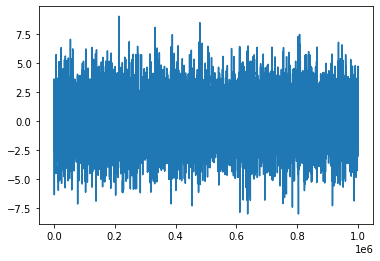

In [17]:
plt.plot(us)
plt.show()


100%|██████████| 250/250 [00:04<00:00, 59.54it/s]


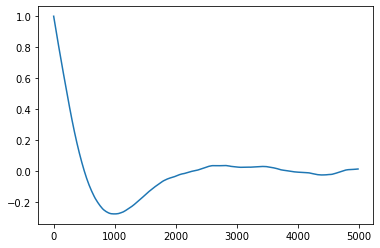

In [18]:
def autocorr(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))[0, 1]

burnin = 5000
ys_burned = ys[burnin:]
us_burned = us[burnin:]
lags = list(range(1, 5000, 20))
plt.plot(lags, [autocorr(us_burned, l) for l in tqdm(lags)])
plt.show()

4.471049916106566


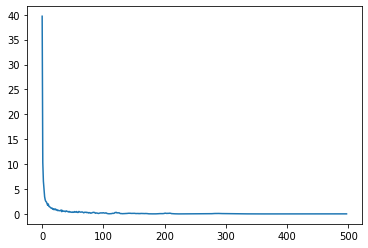

In [40]:
ys_resampled = ys_burned[::100]
us_resampled = us_burned[::100]

print(np.mean(us_resampled**2))
plt.plot(binning(us_resampled**2))
plt.show()

In [41]:
np.mean(MOT1DSModel(84, -16, .048).simulate(0, .05)[1]**2)

100%|██████████| 1000000/1000000 [00:04<00:00, 205019.43it/s]


3.595798099769593